# Make a custom SED plot
This example downloads the pickle file from a fit, and makes sed and f limit plots.

In [1]:
import requests
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import sdf

%matplotlib notebook

In [2]:
mpl.rc('lines', linewidth=3)
mpl.rc('axes', linewidth=1)

In [3]:
s = requests.get('http://drgmk.com/sdb/seds/masters/sdb-v1-163335.38-153041.6/public/'
                 'sdb-v1-163335.38-153041.6-mnest/phoenix_m_av_.pkl')
r = pickle.loads(s.content)
        
# refill these, as they're deleted to save space when the pickle is saved
mod,plmod = sdf.model.get_models(r.obs,r.model_comps)
r.models = mod
r.pl_models = plmod

<IPython.core.display.Javascript object>


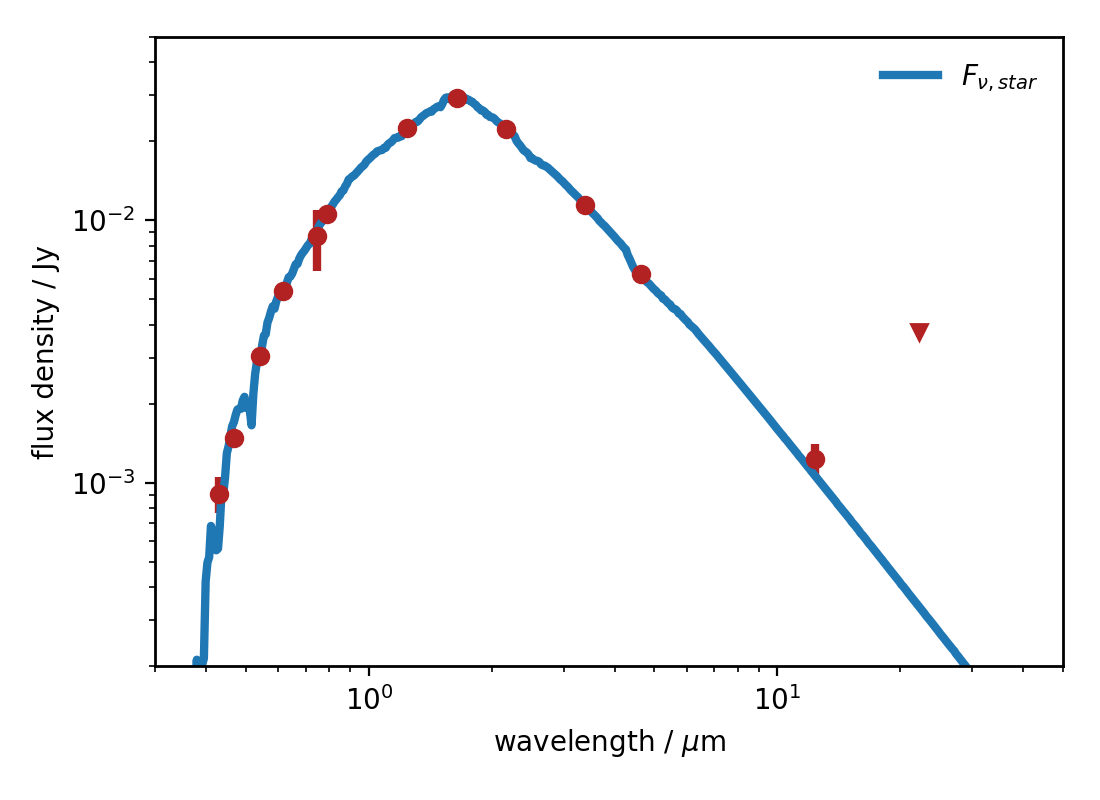

In [4]:
# make the plot
fig,ax = plt.subplots(figsize=(5.5,4))

# stellar and total spectra
# ax.plot(r.total_spec.wavelength,r.total_spec.fnujy,color='C2',label='$F_{\\nu,total}$')
ax.loglog(r.comp_spectra[0].wavelength,r.comp_spectra[0].fnujy,label='$F_{\\nu,star}$')

# photometry
for p in r.obs:
    if not isinstance(p,sdf.photometry.Photometry):
        continue

    ok = np.invert(np.logical_or(p.upperlim,p.ignore))
    for i,f in enumerate(p.filters):
        if sdf.filter.iscolour(f):
            ok[i] = False

    ax.errorbar(p.mean_wavelength()[ok],p.fnujy[ok],yerr=p.e_fnujy[ok],
                fmt='o',color='firebrick')
    ax.plot(p.mean_wavelength()[p.upperlim],p.fnujy[p.upperlim],'v',color='firebrick')

# annotation
ax.set_ylim(2e-4,0.05)
ax.set_xlim(0.3,50)
ax.set_ylabel('flux density / Jy')
ax.set_xlabel('wavelength / $\mu$m')

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('sed.pdf')

<IPython.core.display.Javascript object>


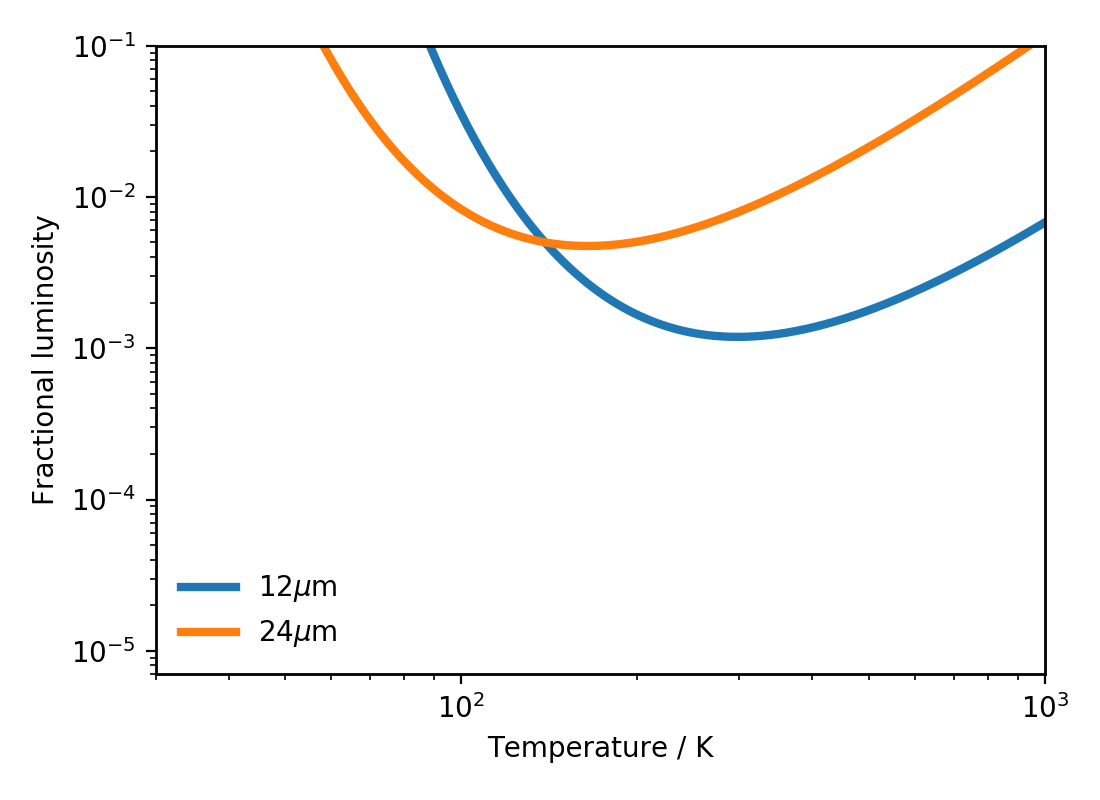

In [5]:
bb = sdf.analytics.BB_Disk()
labels = ['$12\mu$m','$24\mu$m']
lim,_ = bb.f_limits_from_result(r)

fig,ax = plt.subplots(figsize=(5.5,4))

for i in range(lim.shape[1]):
    ax.loglog(bb.temperatures,lim[:,i],label=labels[i])
    
ax.set_xlabel('Temperature / K')
ax.set_ylabel('Fractional luminosity')

ax.set_xlim(30,1000)
ax.set_ylim(0.7e-5,1e-1)

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('f_T.pdf')